# Computing with Oscillators: A Speech Demo

* author: Nand Chandravadia

***

This demo notebook is based on:

- **Part 1: Speech Data**
- **Part 2: Oscillator Model**

In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic
 
%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud
%wait_for_runtime hpc_cpu --live
%switch_runtime hpc_cpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.1.4.post4) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>               

Output()

Authenticated.

Requesting runtime=hpc_cpu...
[NeuroData25VC1:cloud, 60 Minutes, 1 Node(s), 4 CPU(s), 0 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.10', 'pip', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'tqdm', 'scipy', 'scikit-learn', 'pyyaml']
* pip=['torch', 'torchaudio', 'soundfile']
* mounts=[]
Requested runtime=hpc_cpu
Request successful: runtime=hpc_cpu


Output()

local:/tmp/connection_qhon5_25.json --> hpc_cpu:connection_qhon5_25.json... [200]
started proc_name=hpc_cpu_kernel on rt=hpc_cpu. pid=1838
forwarding ports=[13345, 13346, 13347, 13348, 13349]
hpc_cpu:13345 -> access via 18.118.140.230:10000
hpc_cpu:13346 -> access via 18.118.140.230:10001
hpc_cpu:13347 -> access via 18.118.140.230:10002
hpc_cpu:13348 -> access via 18.118.140.230:10003
hpc_cpu:13349 -> access via 18.118.140.230:10004
started ipykernel tunnels for hpc_cpu at 18.118.140.230
started ipykernel client for hpc_cpu
Remote Jupyter kernel launched and connected for runtime=hpc_cpu.
Switched to runtime=hpc_cpu.


In [2]:
!git clone https://github.com/cyber-shuttle/NeuroDATA_2025 workspace

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
Cloning into 'workspace'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 59 (delta 22), reused 46 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 3.44 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (22/22), done.
cell finished on hpc_cpu.


In [3]:
cd workspace

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
/home/exouser/cybershuttle/workspace/PROCESS_14077976-65fd-4e7c-9ede-c072ade175ed/workspace
cell finished on hpc_cpu.


## Part 1: Speech Data

Speech is typically recorded on a microphone, such as the one on your cell-phone or laptop. Standard audio recorders usually record at sampling rates of 48 kHz. Here, we will look at two speech datasets of English and Arabic Speech. 

In [4]:
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, Image, display
from torch.distributions.uniform import Uniform
import yaml

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on Device: {}".format(device))

plt.style.use('seaborn-v0_8')

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
Running on Device: cpu
cell finished on hpc_cpu.


### Load Speech Data

All the speech data is found in `/data'

In [5]:
audio_path = "./data/English_7.wav"
#audio_path = "./data/English_0.wav"
#audio_path = "./data/Arabic_5.wav"
#audio_path = "./data/Arabic_9.wav"

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [6]:
#Specify language dataset 
language = "English" #{"English, Arabic"}

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [7]:
#load speech data params 
def load_speech_data_parameters(language):

    with open("data.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Choose which model config to use
    data_config = config["data"][language]

    
    # specific hyperparameters    
    data_params = {
        "original_sampling_rate": data_config["original_sampling_rate"],
        "batch_length": data_config["batch_length"],
        "downsample_length": data_config["downsample_length"],
        "final_sample_length": data_config["final_sample_length"],
    }

    return data_params

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [8]:
data_params = load_speech_data_parameters(language)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [9]:
print(data_params)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
{'original_sampling_rate': 48000, 'batch_length': 48000, 'downsample_length': 8000, 'final_sample_length': 8000}
cell finished on hpc_cpu.


In [10]:
def load_speech(path, data_params):

    #load raw data
    audio, sample_rate = torchaudio.load(path)

    target_length = data_params["batch_length"] #48000
    current_length = audio.shape[1]

    padding = torch.zeros((audio.shape[0], target_length - current_length))
    audio = torch.cat((audio, padding), dim=1)
    

    #downsample to 8kHz
    original_sampling_rate = data_params["original_sampling_rate"]
    new_sampling_rate = data_params["downsample_length"]
    
    transform = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, 
                                            new_freq=new_sampling_rate)

    #appy new sampling rate
    signal = transform(audio)
    
    #apply a normalization [-1, 1]
    max_value = signal[0,:].abs().max()
    new_signal=signal[0,:]*(1/max_value)
    

    return new_signal, new_sampling_rate


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [11]:
new_signal, new_sampling_rate = load_speech(audio_path, data_params)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [12]:
Audio(data=new_signal, rate=new_sampling_rate)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


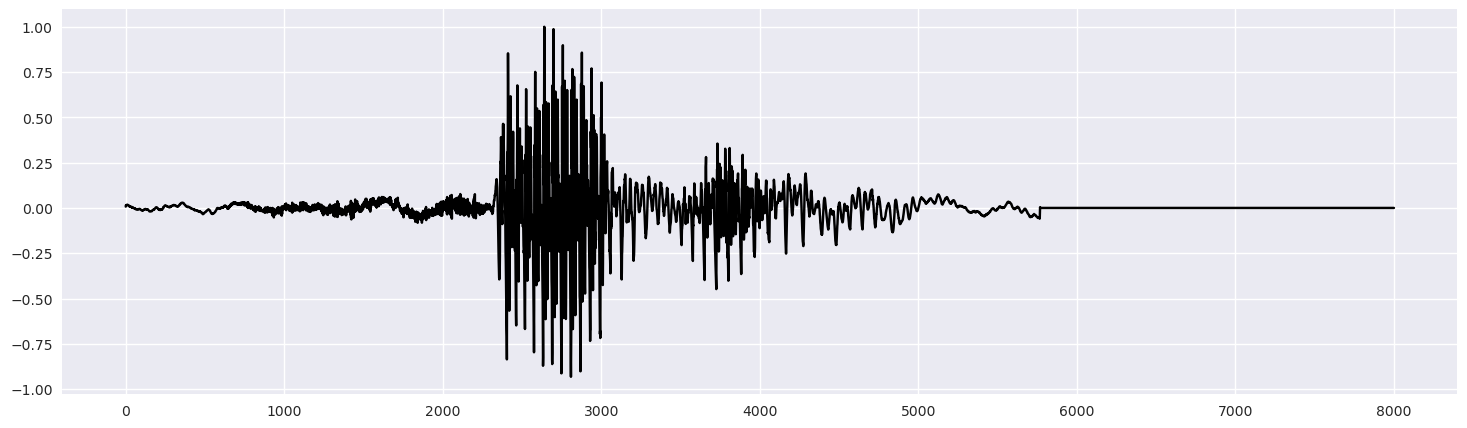

cell finished on hpc_cpu.


In [13]:
time = np.linspace(start = 0, stop = len(new_signal), num = len(new_signal))

fig, axes = plt.subplots(1,1, figsize = (18, 5))

axes.plot(time, new_signal, color = 'black')


axes.grid(True)

# Part 2: Model: Network of Coupled Oscillators

Now, let's look at the form and structure of the model. 

<div style="text-align: center;">
  <img src="assets/network_oscillators.png" alt="Oscillatory Network" width="500" height="500"/>
</div>

In [14]:
from model import coRNN

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [15]:
#User Specify Model
model_number = 1 #{1,2}

######################################
model_id = language + "_" + str(model_number)
network_path_trained = "./models/" + language + "_" + str(model_number) + "_" + "trained" + ".pth"
network_path_untrained = "./models/" + language + "_" + str(model_number) + "_" + "untrained" + ".pth"

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [16]:
def load_hyperparameters(model_id, device):
    # Load the hyperparams file
    with open("hyperparams.yaml", "r") as f:
        config = yaml.safe_load(f)

    # Choose which model config to use
    model_config = config["models"][model_id]

    # Set the seed
    generator = torch.Generator(device=device)
    generator.manual_seed(model_config["random_seed"])

    # Define frequency range
    low_frequency, high_frequency = 0.1, 20
    gamma_tensor = (high_frequency - low_frequency) * torch.rand((1, model_config["n_hid"]), generator=generator, device=device) + low_frequency

    # Define damping range
    low_damping, high_damping = 0.1, 80
    epsilon_tensor = (high_damping - low_damping) * torch.rand((1, model_config["n_hid"]), generator=generator, device=device) + low_damping

    
    # specific hyperparameters    
    params = {
        "network_type": model_config["network_type"],
        "n_inp": model_config["n_inp"],
        "n_hid": model_config["n_hid"],
        "n_out": model_config["n_out"],
        "dt": model_config["dt"],
        "learning_rate": model_config["learning_rate"],
        "random_seed": model_config["random_seed"]
    }

    return params, gamma_tensor, epsilon_tensor
    

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [17]:
params, gamma_tensor, epsilon_tensor = load_hyperparameters(model_id, device)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [18]:
print(params)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
{'network_type': 'coRNN', 'n_inp': 1, 'n_hid': 256, 'n_out': 10, 'dt': 0.005, 'learning_rate': 0.0042, 'random_seed': 24628}
cell finished on hpc_cpu.


In [19]:
print(gamma_tensor)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
tensor([[ 7.8613,  1.0077,  4.7195, 13.4949,  7.6647,  2.0201,  6.9931, 13.4174,
          9.7780, 18.2967, 19.9631, 15.8279,  1.1263,  7.0089, 17.7085, 17.0570,
          7.6989,  3.3233,  9.6993, 11.2107,  1.7946, 10.1130, 19.4571, 13.3016,
         19.2667,  3.5794, 12.4254, 13.7239, 15.2026,  8.3801,  1.7940,  8.4174,
         18.0247,  3.8080, 13.0533, 19.7540,  9.6618,  5.1778, 12.4505, 13.9825,
          6.9068, 17.0931,  8.6965,  6.9704, 16.5019, 17.4211,  8.8425,  1.6590,
          5.7902,  3.1707,  0.7207, 12.3089, 14.4601, 13.0735, 11.5905, 17.3599,
          9.9288, 16.7873,  3.4421, 10.6496, 18.5986,  0.2538,  6.0012,  2.2302,
          3.1097,  5.1532,  5.8395, 17.4563,  8.1956,  3.7415, 15.8989, 10.1049,
         18.2314,  8.2609, 16.6078, 16.3023,  8.6227, 10.3097, 11.1472,  2.6259,
          8.6369, 13.3256, 18.6681, 19.5411,  7.4856,  1.3257,  2.9586,  5.9192,
          3.6963,  5.8530, 12.3569,  4.

In [20]:
print(epsilon_tensor)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
tensor([[ 9.1657, 35.1397, 29.3703, 29.6051, 56.4432,  4.9828, 36.1747, 21.7985,
         48.6989, 49.3014, 59.9319, 22.0833, 20.7058, 31.4175, 68.0192, 40.9550,
         28.8010, 14.7270, 76.9509, 62.2166, 42.5018, 49.7918, 14.7723, 42.2236,
         11.0398, 72.9159,  6.2992, 49.7665, 70.3598, 36.3175, 74.6342,  4.6918,
         52.5693, 47.1548, 49.7644, 68.9114, 65.3404,  8.1223, 52.6573, 64.3208,
          3.7439,  8.7806, 34.5338,  0.2282, 15.5233, 40.9898,  5.7475, 59.1057,
         25.0199, 17.6532, 67.6664, 30.7244,  4.4168, 48.0957, 79.7971, 76.0500,
         50.7348, 53.8768, 71.1370,  4.9016, 63.8765, 53.6046, 17.5029,  0.2441,
         69.8457, 77.3553, 25.8168, 37.4584, 72.9177, 13.5230, 27.4026, 20.9395,
         57.4108, 20.0322,  9.3859, 13.8566, 32.2373,  6.4466, 22.7117, 58.5520,
          7.5236, 24.3377, 35.4656, 18.3019, 59.1045, 42.4469, 34.2989, 71.0974,
          0.9844, 79.7836, 37.1822, 75.

In [21]:
#load the untrained and trained model

def load_model(network_path, params, gamma_tensor, epsilon_tensor, device):

    #params
    network_type = params["network_type"]
    n_inp = params["n_inp"]
    n_hid = params["n_hid"]
    n_out = params["n_out"]
    dt = params["dt"]

    #load model
    model = coRNN(network_type = network_type, n_inp = n_inp, n_hid = n_hid,
                                  n_out = n_out, dt = dt, 
                                  gamma = gamma_tensor, epsilon = epsilon_tensor)

    # Load the saved state dictionary into the model
    model.load_state_dict(torch.load(network_path, map_location=device))

    # Set the model to evaluation mode
    model.eval()
    
    return model

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [22]:
untrained_model = load_model(network_path=network_path_untrained, params=params, gamma_tensor=gamma_tensor, epsilon_tensor=epsilon_tensor, device=device)
trained_model = load_model(network_path=network_path_trained, params=params, gamma_tensor=gamma_tensor, epsilon_tensor=epsilon_tensor, device=device)

untrained_model_weights = untrained_model.state_dict()
trained_model_weights = trained_model.state_dict()

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [23]:
#LOAD MODEL WEIGHTS

def load_model_weights(model):

    #load model weights!
    recurrent_weights = model["cell.R.weight"]
    recurrent_velocity_weights = model["cell.F.weight"]

    return recurrent_weights, recurrent_velocity_weights

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


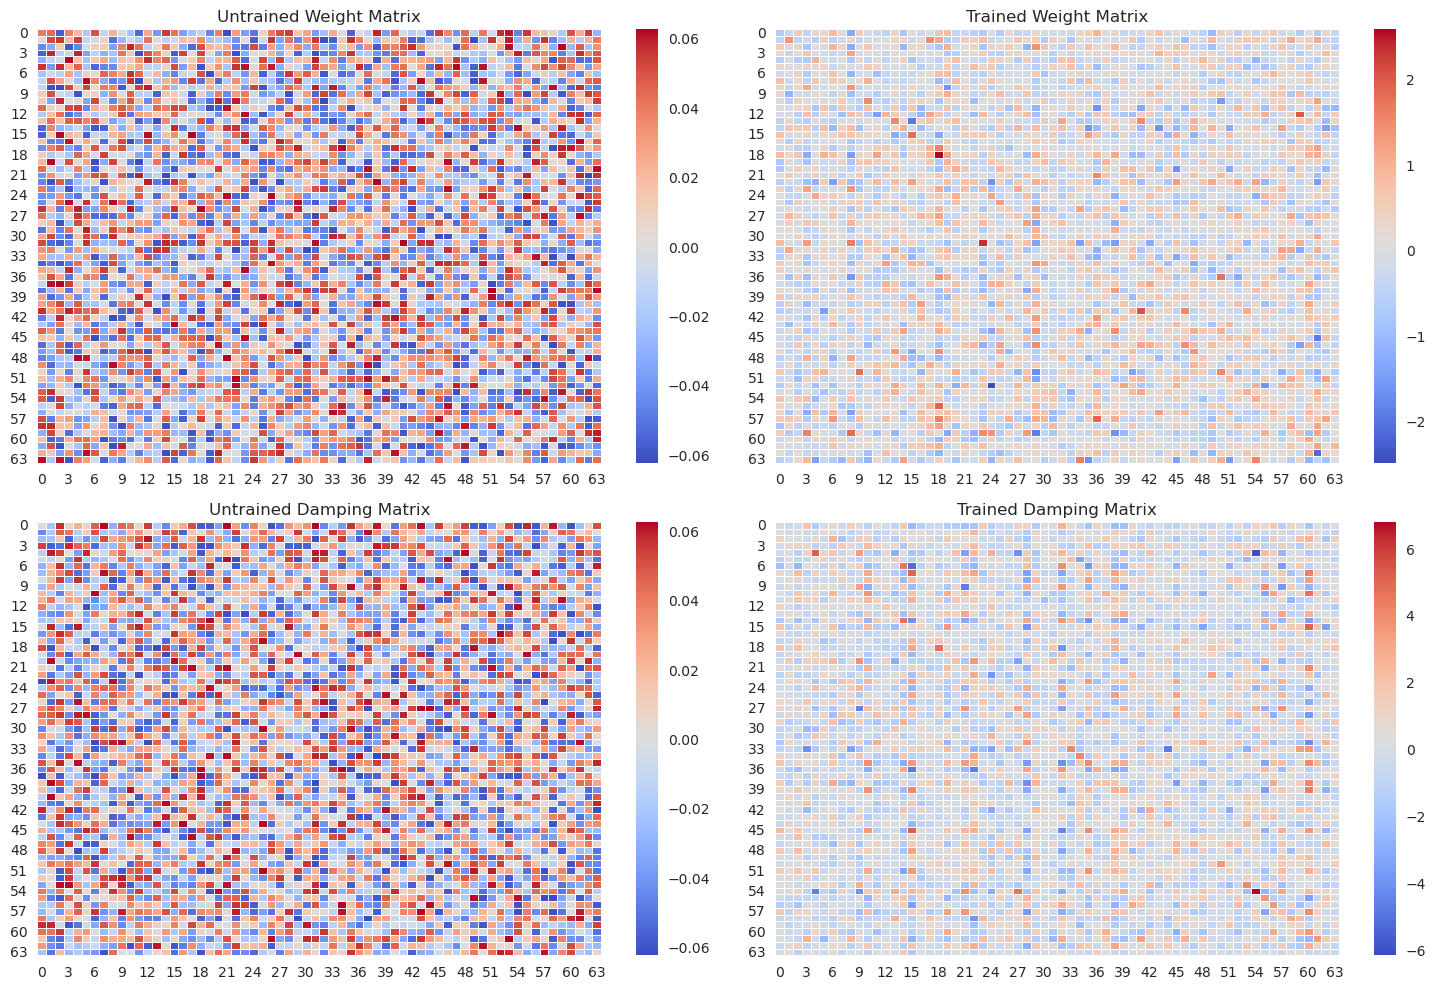

cell finished on hpc_cpu.


In [24]:
# Visualize Model WEIGHTS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

untrained_weights, untrained_damping = load_model_weights(untrained_model_weights)
trained_weights, trained_damping = load_model_weights(trained_model_weights)

index_start, index_end = 0, 64
# Plot the first heatmap on the left subplot
sns.heatmap(untrained_weights[index_start:index_end, index_start:index_end], ax=axes[0,0], cmap='coolwarm', linewidth=0.5)
axes[0,0].set_title('Untrained Weight Matrix')

sns.heatmap(untrained_damping[index_start:index_end, index_start:index_end], ax=axes[1,0], cmap='coolwarm', linewidth=0.5)
axes[1,0].set_title('Untrained Damping Matrix')


# Plot the second heatmap on the right subplot
sns.heatmap(trained_weights[index_start:index_end, index_start:index_end], ax=axes[0,1],cmap='coolwarm', linewidth=0.5)
axes[0,1].set_title('Trained Weight Matrix')

sns.heatmap(trained_damping[index_start:index_end, index_start:index_end], ax=axes[1,1],cmap='coolwarm', linewidth=0.5)
axes[1,1].set_title('Trained Damping Matrix')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
#Feed the Model Speech!

#format input
new_signal = new_signal.reshape(1, 1, data_params["final_sample_length"])  #8000
new_signal = new_signal.permute(2, 0, 1)
input_signal = new_signal


save_output_trained, save_hy_trained, save_hz_trained, save_activation_trained = trained_model(input_signal)
save_output_untrained, save_hy_untrained, save_hz_untrained, save_activation_untrained = untrained_model(input_signal)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [26]:
#What does the model think?

def plot_response(signal, output, title_name, axes):

    SAMPLING_FREQUENCY = data_params["final_sample_length"]
    TIME=1
    
    input = signal[:,0,0]
    output = output[:, 0, :]
    softmax = torch.nn.Softmax(dim=1)
    output = softmax(output)


    color_map = {
    0: "navy",
    1: "darkgreen",
    2: "maroon",
    3: "purple",
    4: "teal",
    5: "olive",
    6: "sienna",
    7: "royalblue",
    8: "darkorange",
    9: "indigo"}

 

    time = torch.arange(start=0, end=TIME, step=1/SAMPLING_FREQUENCY)

    for target in range(0,10):
        axes.plot(time, output.detach()[:, target], label = target, color = color_map[target], alpha = 0.7, linewidth=3)


    #set axes
    title = "Model Prediction" + "," + title_name
    axes.set_title(title, fontsize=24)
    
    axes.set_xlabel("Time (in seconds)", fontsize=18)
    axes.set_ylabel("Probability", fontsize=18)
    axes.set_ylim(-0.05,1.05)
    axes.tick_params(axis='both', labelsize=18)  # Set tick label size 
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
    axes.grid(True)


    return


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


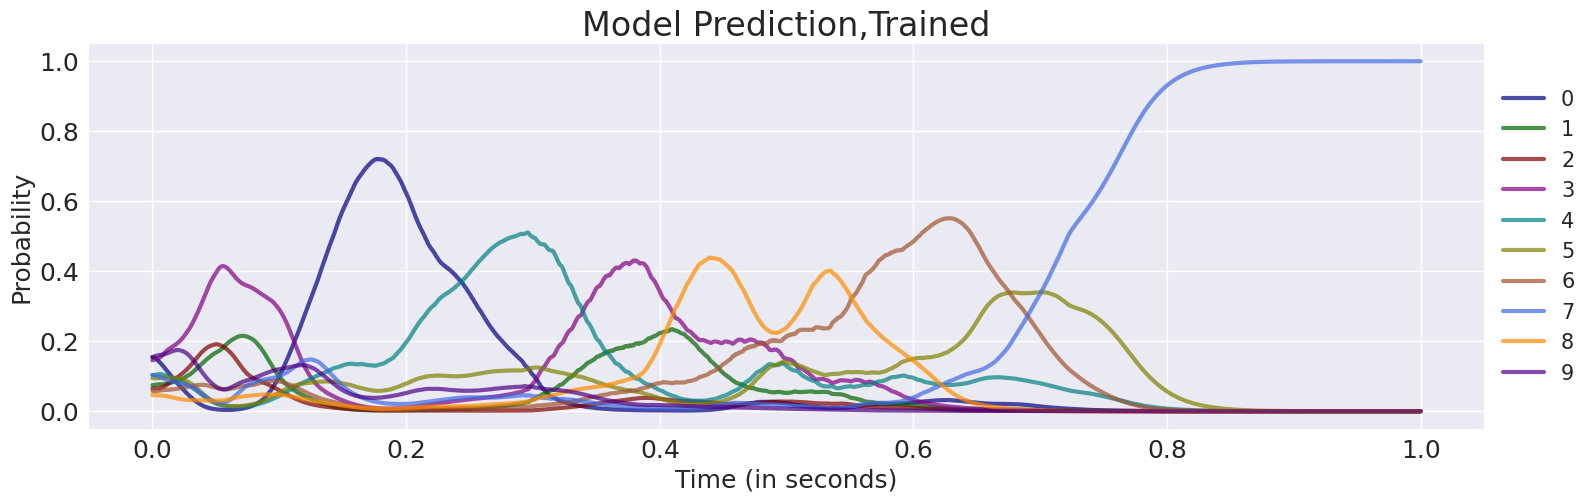

cell finished on hpc_cpu.


In [27]:
fig, axes = plt.subplots(1, 1, figsize=(18,5))

plot_response(signal=input_signal, 
            output=save_output_trained, 
            title_name="Trained",
            axes = axes)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


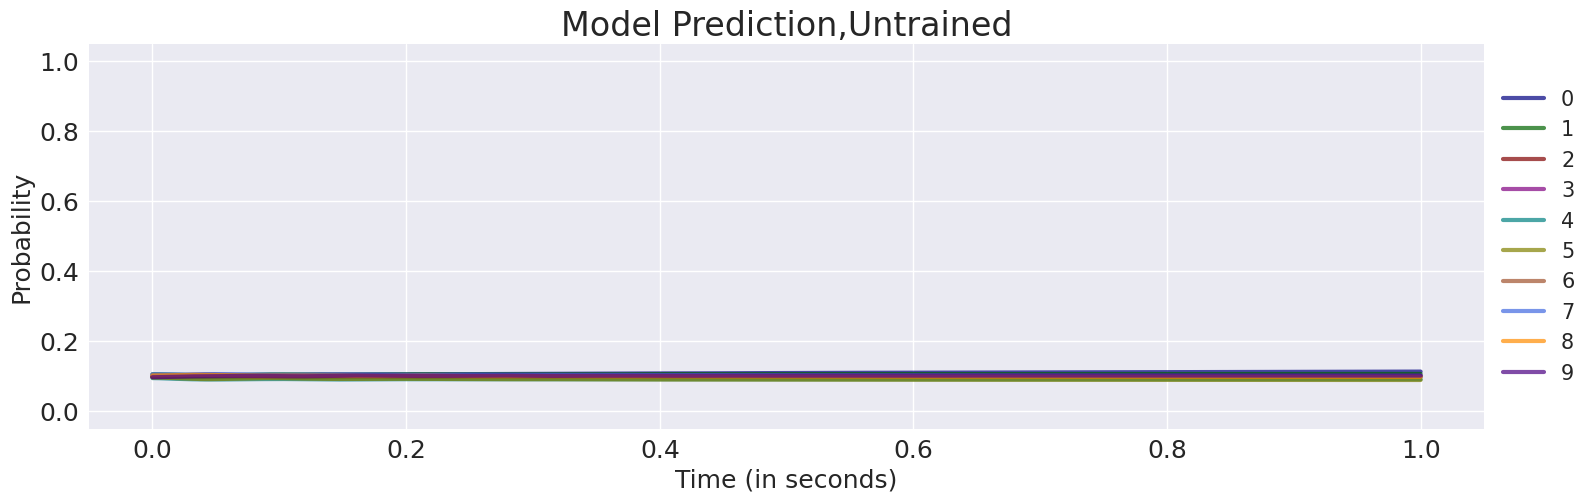

cell finished on hpc_cpu.


In [28]:
fig, axes = plt.subplots(1, 1, figsize=(18,5))

plot_response(signal=input_signal, 
            output=save_output_untrained, 
            title_name="Untrained",
            axes = axes)

In [29]:
%stop_runtime hpc_cpu
%switch_runtime local

Terminated runtime=hpc_cpu. state={'experimentId': 'CS_Agent_87bbc240-a530-4daa-a10c-393031977186', 'terminated': True}
Switched to runtime=local.
